In [82]:
import pandas as pd
import numpy as np
import librosa as lr
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LSTM
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
import nlpaug.augmenter.audio as ag

In [2]:
# Initialize data directory
data_dir = os.path.join(os.getcwd(), 'data')
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

In [3]:
df = pd.read_csv(
    os.path.join(data_dir, 'breath_cycles_updated.csv'), index_col=0)
file_paths = df['chunk_names']

# Values set when loading audio files
n_fft = 256
hop_length = 512
n_mels = 40
df


,Start,End,Crackles,Wheezes,duration,start_index,end_index,start_index_int,end_index_int,y_segment,source,chunk_names
0,0.036,0.579,0,0,0.543,793.80,12766.95,793,12766,[-0.04873171 -0.04849143 -0.04823481 ... -0.08675144 -0.08687682\n -0.08693124],101_1b1_Al_sc_Meditron,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/101_1b1_Al_sc_Meditron_chunk0.wav
1,0.579,2.450,0,0,1.871,12766.95,54022.50,12766,54022,[-0.08709788 -0.08723557 -0.08731082 ... -0.02195927 -0.02181599\n -0.02169704],101_1b1_Al_sc_Meditron,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/101_1b1_Al_sc_Meditron_chunk1.wav
2,2.450,3.893,0,0,1.443,54022.50,85840.65,54022,85840,[-0.02180955 -0.02179321 -0.02166934 ... -0.12314763 -0.12324389\n -0.12332696],101_1b1_Al_sc_Meditron,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/101_1b1_Al_sc_Meditron_chunk2.wav
3,3.893,5.793,0,0,1.900,85840.65,127735.65,85840,127735,[-0.12341598 -0.12354963 -0.12356759 ... 0.04257121 0.04275629\n 0.04287489],101_1b1_Al_sc_Meditron,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/101_1b1_Al_sc_Meditron_chunk3.wav
4,5.793,7.521,0,0,1.728,127735.65,165838.05,127735,165838,[ 0.04297349 0.04315756 0.04330058 ... -0.0639165 -0.06329159\n -0.06283387],101_1b1_Al_sc_Meditron,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/101_1b1_Al_sc_Meditron_chunk4.wav
...,...,...,...,...,...,...,...,...,...,...,...,...
6,11.721,13.693,1,0,1.972,258448.05,301930.65,258448,301930,[-0.04730458 -0.04737562 -0.04761335 ... 0.03817879 0.03843744\n 0.03883443],226_1b1_Pl_sc_LittC2SE,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/226_1b1_Pl_sc_LittC2SE_chunk6.wav
7,13.693,15.536,0,0,1.843,301930.65,342568.80,301930,342568,[0.03921689 0.03942744 0.03974621 ... 0.02950672 0.02939099 0.02952257],226_1b1_Pl_sc_LittC2SE,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/226_1b1_Pl_sc_LittC2SE_chunk7.wav
8,15.536,17.493,0,0,1.957,342568.80,385720.65,342568,385720,[0.02966898 0.02972315 0.02984862 ... 0.00599799 0.00647474 0.00691334],226_1b1_Pl_sc_LittC2SE,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/226_1b1_Pl_sc_LittC2SE_chunk8.wav
9,17.493,19.436,1,0,1.943,385720.65,428563.80,385720,428563,[0.00744156 0.00786917 0.00829501 ... 0.16827123 0.1684439 0.16842398],226_1b1_Pl_sc_LittC2SE,/home/raghav1881/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/data/pre_processed_audio/chunks/226_1b1_Pl_sc_LittC2SE_chunk9.wav


In [4]:
def load_file(file_path, n_fft=256, hop_length=512, n_mels=40):
    mel_specs = {}
    max_mel = {}
    min_mel = {}
    pad_length = 0

    for file_path in file_paths:
        y, sr = lr.load(file_path)
        mel_spec = lr.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels)
        max_mel, min_mel = np.amax(mel_spec), np.amin(mel_spec)
        normalized_mel_spec = (mel_spec - min_mel) / (max_mel - min_mel)
        key = os.path.basename(file_path)[:3]
        pad_length = max(pad_length, normalized_mel_spec.shape[1])

        if key in mel_specs:
            mel_specs[key].append(normalized_mel_spec)
        else:
            mel_specs[key] = [normalized_mel_spec]

    return mel_specs, max_mel, min_mel, pad_length



In [5]:
mel_specs, max_mel, min_mel, pad_length = load_file(file_paths)


In [6]:
mel_specs['102'][0].shape

(40, 64)

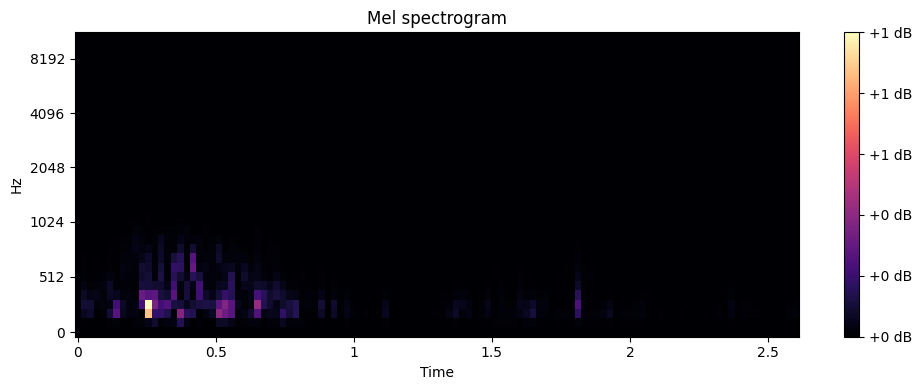

In [8]:
plt.figure(figsize=(10, 4))
lr.display.specshow(mel_specs['107'][3], x_axis='time',
                    y_axis='mel', hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()


In [9]:
def mel_padding(mel, pad_length):
    time_diff = pad_length - mel.shape[1]
    left_pad = time_diff // 2
    right_pad = time_diff - left_pad
    padded_mel = np.pad(mel, ((0, 0), (left_pad, right_pad)), mode='constant', constant_values=0)
    return padded_mel


In [10]:
padded_mels = {}
for key, values in mel_specs.items():
    for mel in values:
        if key in padded_mels:
            padded_mels[key].append(mel_padding(mel, pad_length))
        else:
            padded_mels[key] = [mel_padding(mel, pad_length)]


In [11]:
def label_dict(df):
    labels_dict = {}

    for index, row in df.iterrows():
        array_labels = []
        key = row['source'][:3]
        crackle, wheeze = row["Crackles"], row['Wheezes']
        array_labels.append([crackle, wheeze])
        if key in labels_dict:
            labels_dict[key]= np.vstack((labels_dict[key], array_labels))
        else:
            labels_dict[key] = np.array(array_labels)
    return labels_dict

In [12]:
labels_dict = label_dict(df)

In [13]:
print(labels_dict['101'].shape)

(23, 2)


In [14]:
def array_reshape(X):
    d1, d2, d3 = X.shape
    X = X.reshape((d3, d1, d2, 1))
    return X

def stack_arrays(padded_dict, labels_dict, keys):
    stack_list = []
    stack_array_Y = None
    
    for key in keys:
        stacked_arrs = []
        if stack_array_Y is None:
            stack_array_Y = labels_dict[key]
        else:
            stack_array_Y = np.vstack((stack_array_Y, labels_dict[key]))
        for arr in padded_dict[key]:
            stacked_arr = np.expand_dims(arr, axis=2)
            stacked_arrs.append(stacked_arr)
        stacked_arr = np.concatenate(stacked_arrs, axis=2)
        stack_list.append(stacked_arr)
    stack_array_X = np.concatenate(stack_list, axis=2)
    
    return stack_array_X, stack_array_Y

def train_test_split_dict(padded_dict, labels_dict):
    Y_train, Y_val, Y_test = None, None, None
    n = len(padded_dict.keys())
    keys_shuffled = list(padded_dict.keys())
    
    random.shuffle(keys_shuffled)
    split_train, split_val = math.ceil(n * 0.5), math.ceil(n * 0.3)

    train_keys = keys_shuffled[:split_train]
    val_keys = keys_shuffled[split_train:split_train+split_val]
    test_keys = keys_shuffled[split_train+split_val:]
    
    X_train, Y_train = stack_arrays(padded_dict, labels_dict, train_keys)
    X_val, Y_val = stack_arrays(padded_dict, labels_dict, val_keys)
    X_test, Y_test = stack_arrays(padded_dict, labels_dict, test_keys)

    X_train = array_reshape(X_train)
    X_val = array_reshape(X_val)
    X_test = array_reshape(X_test)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

         

In [15]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = train_test_split_dict(padded_mels, labels_dict)


In [30]:
def shuffle_data(X, Y):
    rng = np.random.default_rng(seed = 42)
    rng.shuffle(X)
    rng.shuffle(Y)
    return X, Y

In [31]:
X_train, Y_train = shuffle_data(X_train, Y_train)
X_val, Y_val = shuffle_data(X_val, Y_val)
X_test, Y_test = shuffle_data(X_test, Y_test)

In [90]:
X_train.shape

(3625, 40, 697, 1)

In [85]:
aug = ag.VtlpAug(4480)
augmented_data = aug.augment(X_train)

/home/raghav1881/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(


MemoryError: Unable to allocate 46.2 GiB for an array with shape (217, 40, 697, 2049) and data type float32

In [91]:
input_shape = (n_mels, pad_length, 1)
model = Sequential()
model.add(Conv2D(2, kernel_size=(2, 2), activation="relu",
          input_shape=input_shape, dilation_rate=2))

model.add(Conv2D(4, kernel_size=(2, 2), activation='relu', dilation_rate=2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=0.000001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])
model.summary()
history = model.fit(X_train, Y_train, batch_size=64,
                    epochs=40, validation_data=(X_val, Y_val))


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 38, 695, 2)        10        
                                                                 
 conv2d_75 (Conv2D)          (None, 36, 693, 4)        36        
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 18, 346, 4)       0         
 g2D)                                                            
                                                                 
 flatten_37 (Flatten)        (None, 24912)             0         
                                                                 
 dense_74 (Dense)            (None, 8)                 199304    
                                                                 
 dense_75 (Dense)            (None, 2)                 18        
                                                     

Accuracy: 85%
Loss: 0.3883



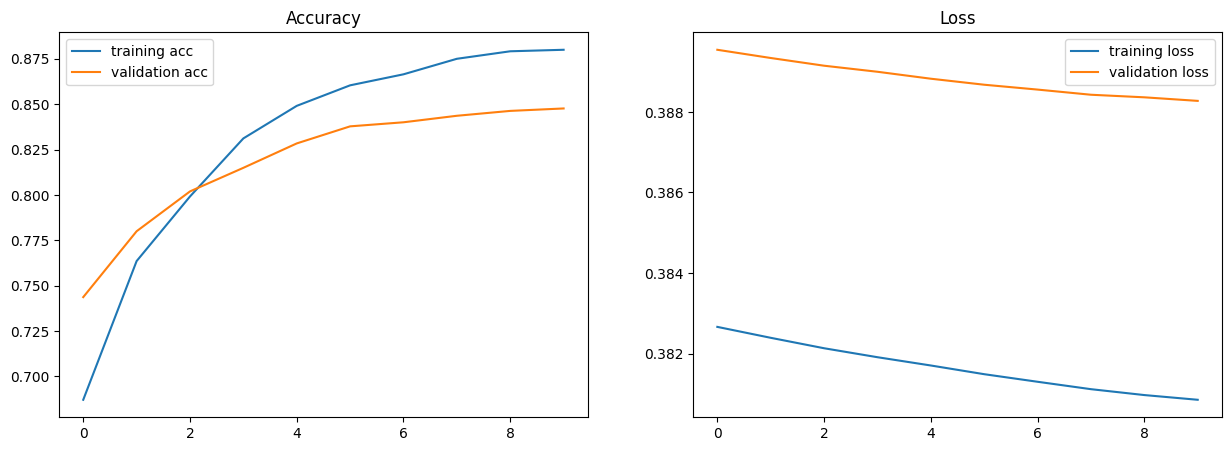

In [ ]:
score = model.evaluate(X_val, Y_val, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='training acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
